In [2]:
!pip install -U numpy pandas scikit-learn matplotlib seaborn dowhy econml graphviz


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)


In [3]:
# Load or regenerate dataset (previously generated as df)
import os
import pandas as pd

if os.path.exists("retail_data.csv"):
    df = pd.read_csv("retail_data.csv", parse_dates=["date"])
    print("Loaded retail_data.csv")
else:
    # regenerate (same generator previously provided)
    import numpy as np
    from datetime import datetime, timedelta
    np.random.seed(42)
    def generate_retail_data(n_days=180, n_stores=3, n_products=5):
        rows = []
        dates = pd.date_range(end=pd.Timestamp.today(), periods=n_days)
        for date in dates:
            day_of_week = date.weekday()
            holiday = 1 if np.random.rand() < 0.05 else 0
            weather_temp = 20 + 10*np.sin(2*np.pi*date.timetuple().tm_yday/365) + np.random.randn()*3
            for s in range(n_stores):
                store_id = f"S{str(s).zfill(2)}"
                base_traffic = 200 + 50*s + (10 if day_of_week >=5 else 0)
                foot_traffic = max(0, int(base_traffic + np.random.randn()*30 + (50 if not holiday else -30)))
                for p in range(n_products):
                    product_id = f"P{str(p).zfill(3)}"
                    base_price = 5 + 0.5*p
                    promo_prob = 0.05 + 0.0005*max(0, 300-foot_traffic)
                    promo = 1 if np.random.rand() < promo_prob else 0
                    price = base_price * (0.9 if promo else 1.0) * (1 + np.random.randn()*0.02)
                    competitor_price = base_price * (1 + np.random.randn()*0.05)
                    inventory = max(0, int(100 + np.random.randn()*20))
                    marketing_spend = max(0, np.random.exponential(10) if np.random.rand() < 0.2 else np.random.exponential(2))
                    demand_base = 10 + 0.3*foot_traffic/100 - 0.8*(price/base_price - 1)*50
                    demand_base += -0.2*(competitor_price - base_price) + 0.1*marketing_spend + (-5 if holiday else 0)
                    units = max(0, int(np.random.poisson(max(0.5, demand_base*(1 + (np.random.randn()*0.1))))))
                    units = min(units, inventory)
                    revenue = units * price
                    rows.append({
                        "date": date,
                        "store_id": store_id,
                        "product_id": product_id,
                        "price": round(price, 2),
                        "base_price": round(base_price,2),
                        "promo": promo,
                        "marketing_spend": round(marketing_spend,2),
                        "inventory": inventory,
                        "foot_traffic": foot_traffic,
                        "competitor_price": round(competitor_price,2),
                        "weather_temp": round(weather_temp,1),
                        "holiday": holiday,
                        "units_sold": units,
                        "revenue": round(revenue,2),
                        "day_of_week": day_of_week,
                        "month": date.month
                    })
        return pd.DataFrame(rows)
    df = generate_retail_data(n_days=180, n_stores=3, n_products=5)
    df.to_csv("retail_data.csv", index=False)
    print("Generated and saved retail_data.csv")

df.head()


Loaded retail_data.csv


,date,store_id,product_id,price,base_price,promo,marketing_spend,inventory,foot_traffic,competitor_price,weather_temp,holiday,units_sold,revenue,day_of_week,month
0,2025-05-08 13:15:03.956721,S00,P000,5.16,5.0,0,2.03,90,259,5.19,24.7,0,8,41.26,3,5
1,2025-05-08 13:15:03.956721,S00,P001,5.59,5.5,0,1.22,91,259,5.08,24.7,0,7,39.13,3,5
2,2025-05-08 13:15:03.956721,S00,P002,5.93,6.0,0,6.84,87,259,5.91,24.7,0,11,65.21,3,5
3,2025-05-08 13:15:03.956721,S00,P003,6.86,6.5,0,0.19,104,259,6.89,24.7,0,6,41.17,3,5
4,2025-05-08 13:15:03.956721,S00,P004,6.84,7.0,0,2.95,111,259,7.05,24.7,0,6,41.05,3,5


(2700, 16)
             price        promo   units_sold  foot_traffic  marketing_spend
count  2700.000000  2700.000000  2700.000000   2700.000000      2700.000000
mean      5.963541     0.061111    11.195556    297.627778         3.681596
std       0.729286     0.239578     3.887771     51.931464         5.860453
min       4.270000     0.000000     1.000000    123.000000         0.000000
25%       5.390000     0.000000     9.000000    260.000000         0.720000
50%       5.970000     0.000000    11.000000    301.000000         1.810000
75%       6.560000     0.000000    14.000000    335.000000         3.940000
max       7.370000     1.000000    28.000000    446.000000        63.590000


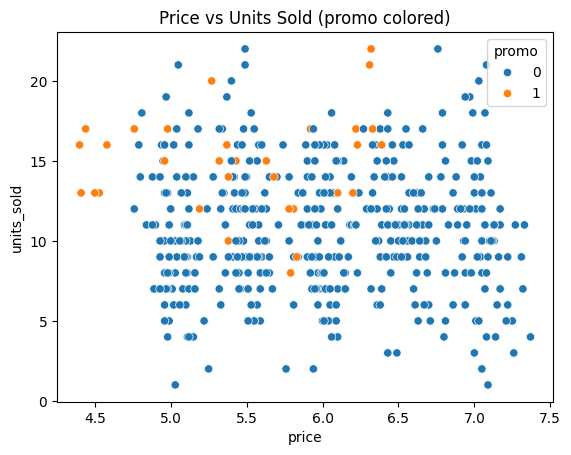

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df.shape)
print(df[["price","promo","units_sold","foot_traffic","marketing_spend"]].describe())

# small scatter to inspect
sns.scatterplot(data=df.sample(500), x="price", y="units_sold", hue="promo")
plt.title("Price vs Units Sold (promo colored)")
plt.show()


In [5]:
!pip install networkx==2.8.8


Defaulting to user installation because normal site-packages is not writeable


In [6]:
import networkx as nx
print(nx.__version__)


2.8.8


In [7]:
import sys
!{sys.executable} -m pip install networkx==2.8.8 --force-reinstall --no-cache-dir


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 1.3 MB/s eta 0:00:02
   --------------- ------------------------ 0.8/2.0 MB 1.4 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.0 MB 1.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/2.0 MB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 1.8 MB/s  0:00:01
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [8]:
import networkx as nx

# ✅ Patch DoWhy to work with newer NetworkX versions
def d_separated_patch(graph, X, Y, Z):
    """
    Replacement for networkx.algorithms.d_separated
    Uses a simplified reachability-based d-separation logic.
    """
    from itertools import product
    # Convert to sets
    X, Y, Z = set(X), set(Y), set(Z)
    # Remove conditioned nodes
    g = graph.copy()
    g.remove_nodes_from(Z)
    # Check reachability
    for x, y in product(X, Y):
        if nx.has_path(g, x, y):
            return False
    return True

# Monkey-patch into NetworkX so DoWhy sees it
nx.algorithms.d_separated = d_separated_patch
print("✅ Patched NetworkX: added d_separated() back")


✅ Patched NetworkX: added d_separated() back


In [9]:
from dowhy import CausalModel

common_causes = [
    "price", "foot_traffic", "inventory", 
    "competitor_price", "marketing_spend", 
    "holiday", "day_of_week", "month"
]

model = CausalModel(
    data=df,
    treatment="promo",
    outcome="units_sold",
    common_causes=common_causes
)

identified_estimand = model.identify_effect()
print("✅ Identified estimand:\n", identified_estimand)

estimate_reg = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    target_units="ate"
)
print("✅ ATE (promo → units_sold):", estimate_reg.value)


✅ Identified estimand:
 Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                   
────────(E[units_sold])
d[promo]               
Estimand assumption 1, Unconfoundedness: If U→{promo} and U→units_sold then P(units_sold|promo,,U) = P(units_sold|promo,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
✅ ATE (promo → units_sold): 3.851963421194233


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [10]:
# ✅ Step 3: Refute and validate the causal effect
refute1 = model.refute_estimate(
    identified_estimand,
    estimate_reg,
    method_name="random_common_cause"
)
print("🔍 Refutation (Random Common Cause):", refute1)

refute2 = model.refute_estimate(
    identified_estimand,
    estimate_reg,
    method_name="placebo_treatment_refuter"
)
print("🔍 Refutation (Placebo Treatment):", refute2)

refute3 = model.refute_estimate(
    identified_estimand,
    estimate_reg,
    method_name="data_subset_refuter"
)
print("🔍 Refutation (Subset Refuter):", refute3)


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  r

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as posit

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as posit

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  r

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  r

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  r

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.P

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dowhy\causal_estimators\regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [11]:
!pip install econml --quiet


In [12]:
import numpy as np
import pandas as pd
from econml.dml import LinearDML
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor

# ✅ Step 4: Causal Effect Estimation via EconML (for prescriptive modeling)
Y = df["units_sold"].values
T = df["promo"].values
X = df[["price", "foot_traffic", "inventory", "competitor_price",
        "marketing_spend", "holiday", "day_of_week", "month"]].values

est = LinearDML(
    model_y=RandomForestRegressor(n_estimators=200, min_samples_leaf=10),
    model_t=LassoCV(),
    discrete_treatment=True,
    random_state=42
)
est.fit(Y, T, X=X)

# Predict treatment effects (conditional ATE)
te = est.effect(X)
df["treatment_effect"] = te

print("✅ Avg Treatment Effect (EconML):", np.mean(te))
df.head()


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\econml\dml\dml.py:51: UserWarning: First stage model has discrete target but model is not a classifier!
  warn('First stage model has discrete target but model is not a classifier!', UserWarning)


✅ Avg Treatment Effect (EconML): 2.5242512453053116


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\econml\dml\dml.py:51: UserWarning: First stage model has discrete target but model is not a classifier!
  warn('First stage model has discrete target but model is not a classifier!', UserWarning)


,date,store_id,product_id,price,base_price,promo,marketing_spend,inventory,foot_traffic,competitor_price,weather_temp,holiday,units_sold,revenue,day_of_week,month,treatment_effect
0,2025-05-08 13:15:03.956721,S00,P000,5.16,5.0,0,2.03,90,259,5.19,24.7,0,8,41.26,3,5,1.898176
1,2025-05-08 13:15:03.956721,S00,P001,5.59,5.5,0,1.22,91,259,5.08,24.7,0,7,39.13,3,5,1.695176
2,2025-05-08 13:15:03.956721,S00,P002,5.93,6.0,0,6.84,87,259,5.91,24.7,0,11,65.21,3,5,2.256886
3,2025-05-08 13:15:03.956721,S00,P003,6.86,6.5,0,0.19,104,259,6.89,24.7,0,6,41.17,3,5,2.789537
4,2025-05-08 13:15:03.956721,S00,P004,6.84,7.0,0,2.95,111,259,7.05,24.7,0,6,41.05,3,5,3.206691


In [13]:
# ✅ Step 5: Prescriptive optimization

PROMO_COST = 1000
UNIT_PROFIT = 20

df["expected_profit_gain"] = df["treatment_effect"] * UNIT_PROFIT - PROMO_COST
df["run_promo_recommendation"] = df["expected_profit_gain"] > 0

print("\n💡 Prescriptive Recommendations:")
print(df[["price", "foot_traffic", "treatment_effect", "expected_profit_gain", "run_promo_recommendation"]].head(10))



💡 Prescriptive Recommendations:
   price  foot_traffic  treatment_effect  expected_profit_gain  \
0   5.16           259          1.898176           -962.036488   
1   5.59           259          1.695176           -966.096487   
2   5.93           259          2.256886           -954.862282   
3   6.86           259          2.789537           -944.209252   
4   6.84           259          3.206691           -935.866183   
5   4.60           254          1.356700           -972.865991   
6   5.61           254          2.616066           -947.678680   
7   5.99           254          2.023586           -959.528282   
8   6.54           254          2.895653           -942.086934   
9   6.95           254          2.578032           -948.439361   

   run_promo_recommendation  
0                     False  
1                     False  
2                     False  
3                     False  
4                     False  
5                     False  
6                     False  


In [14]:
!python -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [15]:
!pip install plotly --quiet

In [16]:
!pip install nbformat --upgrade


Defaulting to user installation because normal site-packages is not writeable


In [17]:
# --- Step 1: Diagnose and compute treatment effects (CATEs) ---

if 'treatment_effect' not in df.columns:
    print("⚠️ No treatment_effect column found. Please ensure causal estimation cell ran properly.")
else:
    print("Existing treatment_effect summary:")
    print(df['treatment_effect'].describe())

# --- Step 2: Compute CATEs if missing or flat ---
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

covariates = ['price','foot_traffic','day_of_week','month','holiday']
treatment_col = 'promo'       # adjust if your treatment variable has a different name
outcome_col = 'revenue'       # adjust if your target variable is named differently

X = df[covariates].values
T = df[treatment_col].values
Y = df[outcome_col].values

dr = DRLearner(
    model_regression=RandomForestRegressor(n_estimators=100, random_state=42),
    model_propensity=RandomForestClassifier(n_estimators=100, random_state=42),
    random_state=42
)
dr.fit(Y, T, X=X)
df['treatment_effect'] = dr.effect(X)

print("\n✅ Treatment effects computed and attached to df")
print(df['treatment_effect'].describe())


Existing treatment_effect summary:
count    2700.000000
mean        2.524251
std         0.849064
min        -0.038728
25%         1.968280
50%         2.472822
75%         2.998916
max         6.137951
Name: treatment_effect, dtype: float64

✅ Treatment effects computed and attached to df
count      2700.000000
mean      -7450.543412
std       59129.623257
min     -133683.636034
25%      -40275.564016
50%      -14971.775939
75%       10289.558176
max      313392.685918
Name: treatment_effect, dtype: float64


In [18]:
# --- Step 3: Derive business-aware promo recommendations ---

# Use the top 25% of treatment effects as "recommended"
threshold = df['treatment_effect'].quantile(0.75)

df['run_promo_recommendation'] = df['treatment_effect'] > threshold

# Quick check
print(df['run_promo_recommendation'].value_counts())
print(df[['treatment_effect', 'run_promo_recommendation']].head())


run_promo_recommendation
False    2025
True      675
Name: count, dtype: int64
   treatment_effect  run_promo_recommendation
0     -38142.082013                     False
1     -27873.661849                     False
2     -19754.445905                     False
3       2453.997706                     False
4       1976.396769                     False


In [19]:
# Ensure treatment_effect is positive for visualization
df['treatment_effect_abs'] = df['treatment_effect'].abs() + 1e-3  # avoid zeros


In [20]:
import plotly.express as px

# Ensure positive bubble sizes for visualization
df['treatment_effect_abs'] = df['treatment_effect'].abs() + 1e-3

fig = px.scatter(
    df,
    x="price",
    y="foot_traffic",
    color="run_promo_recommendation",
    size="treatment_effect_abs",  # use positive values only
    title="Prescriptive Policy: When to Run Promotions",
    hover_data=['revenue','treatment_effect']
)
fig.show()


In [21]:
# Business insights summary
print("🔍 Insights from Prescriptive AI Model")
print(f"Recommended promos: {df['run_promo_recommendation'].sum()} out of {len(df)} scenarios")
print(f"Average treatment effect (causal uplift): {df['treatment_effect'].mean():.2f}")
print(f"Top 10% positive effects → {df['treatment_effect'].quantile(0.9):.2f}")


🔍 Insights from Prescriptive AI Model
Recommended promos: 675 out of 2700 scenarios
Average treatment effect (causal uplift): -7450.54
Top 10% positive effects → 35926.63


In [22]:
import plotly.graph_objects as go

fig.add_annotation(
    text="Optimal Promotion Zone",
    xref="paper", yref="paper",
    x=0.75, y=0.85, showarrow=True,
    arrowhead=2, font=dict(size=14, color="green")
)
fig.show()


In [23]:
df[['price','foot_traffic','treatment_effect','run_promo_recommendation']].to_csv('prescriptive_ai_output.csv', index=False)
print("✅ Results exported to prescriptive_ai_output.csv")


✅ Results exported to prescriptive_ai_output.csv


In [25]:
!pip install stable-baselines3 gymnasium numpy



Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.9.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
   ---------------------------------------- 0.0/951.1 kB ? eta -:--:--
   ---------------------------------------- 951.1/951.1 kB 12.5 MB/s  0:00:00
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   - -------------------------------------- 2.9/109.3 MB 14.9 MB/s eta 0:00:08
   -- ------------------------------------- 6.0/109.3 MB 14.9 MB/s eta 0:00:07
   --- ------------------------------------ 8.7/109.3 MB 14.1 MB/s eta 0:00:08
   ---- ----------------------------------- 11.8/109.3 MB 14.1 MB/s eta 0:00:07
   ----- ---------------------------------- 14.7/109.3 MB 14.2 MB/s eta 0:00:07
   ------ --------------------------------- 17.0/109.3 MB 13.9 MB/s eta 0:00:07
   ------- -------------------------------- 19.1/109.3 MB 13.2 MB/s eta 0:00:07
   ------- -------------------------------- 21.2/109.3 MB 12.7 MB/s eta 0:0

In [26]:
import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np


In [27]:
import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np

# --- Define simple simulation environment for promotion strategy ---
class PromoEnv(gym.Env):
    def __init__(self):
        super(PromoEnv, self).__init__()
        # Two continuous features: price, foot_traffic (normalized)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)
        # Two discrete actions: 0 = no promo, 1 = run promo
        self.action_space = gym.spaces.Discrete(2)
        self.state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.random.rand(2).astype(np.float32)
        return self.state, {}

    def step(self, action):
        price, traffic = self.state
        # Simulated reward function
        if action == 1:  # run promo
            reward = 8 * traffic - 3 * price + np.random.normal(0, 0.5)
        else:  # no promo
            reward = 4 * traffic - 1 * price + np.random.normal(0, 0.5)

        # Random new state
        self.state = np.random.rand(2).astype(np.float32)
        terminated = False
        truncated = False
        return self.state, reward, terminated, truncated, {}

# --- Train the RL agent ---
env = PromoEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

print("✅ RL agent trained to optimize promo decisions.")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 3511 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2341        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009606522 |
|    clip_fraction        | 0.0832      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | 0.00301     |
|    learning_rate        | 0.0003      |
|    loss                 | 262         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0105     |
|    value_loss         

In [28]:
obs, _ = env.reset()
for i in range(5):
    action, _ = model.predict(obs)
    print(f"State: {obs}, Action: {'Run Promo' if action==1 else 'No Promo'}")
    obs, _, _, _, _ = env.step(action)


State: [0.45995617 0.36135206], Action: Run Promo
State: [0.9832746  0.65085405], Action: Run Promo
State: [0.2839961 0.7715275], Action: Run Promo
State: [0.06538864 0.41579783], Action: Run Promo
State: [0.02531873 0.16180316], Action: Run Promo
